In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.cluster import DBSCAN

from module_.dataLoader import dataLoader
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection

from module_.info.config import feature_name

In [26]:
episodes, transitions, labels = dataLoader("testbed")

In [ ]:
from module_.validation import check_active_state_order

threshold = 2

fig = plt.figure(figsize=(20, 5))
ax = plt.axes()
colorstring = "bgrcmk"

sensors = set()
for events in episodes:
    sensors = sensors | set(events[:,0])
sensors = sorted(sensors)

for i in range(len(episodes)):

    if i<32:
        continue

    episode, transition, label = episodes[i], transitions[i], labels[i]
    active_dict = check_active_state_order(episode, "adlmr")

    ax.set_title('Active State of {}'.format(label))
    ax.set_xlabel("Event"); ax.set_ylabel("Sensor")
    ax.set_yticks(range(1, len(active_dict.keys())+1))
    ax.set_yticklabels(active_dict.keys())

    for i, item in enumerate(active_dict.items()):
        k, v = item
        for fragment in v:
            # if fragment[0]>=0 and fragment[1]<=transition_time_r:
                # print(k, fragment)
            coloridx = sensors.index(k)
            ax.hlines(y=i+1, xmin=fragment[0], xmax=fragment[1], linewidth=3, 
                color=colorstring[coloridx%len(colorstring)]
            )

    plt.axvspan(transition-1, transition, 
        facecolor='g', alpha=0.2, label="transition"
    )

    break

In [ ]:
from module_.validation import check_active_state

threshold = 2

fig = plt.figure(figsize=(20, 5))
ax = plt.axes()
colorstring = "bgrcmk"

sensors = set()
for events in episodes:
    sensors = sensors | set(events[:,0])
sensors = sorted(sensors)

for i in range(len(episodes)):

    if i<32:
        continue

    episode, transition, label = episodes[i], transitions[i], labels[i]


    active_dict = check_active_state(episode, "adlmr")

    start_time = float(episode[0,2])
    transition_time_l = float(episode[transition-1,2])-start_time
    transition_time_r = float(episode[transition,2])-start_time

    ax.set_title('Active State of {}'.format(label))
    ax.set_xlabel("Timestamp"); ax.set_ylabel("Sensor")
    ax.set_yticks(range(1, len(active_dict.keys())+1))
    ax.set_yticklabels(active_dict.keys())

    for i, item in enumerate(active_dict.items()):
        k, v = item
        for fragment in v:
            # if fragment[0]>=0 and fragment[1]<=100:
                # print(k, fragment)
            coloridx = sensors.index(k)
            ax.hlines(y=i+1, xmin=fragment[0], xmax=fragment[1], linewidth=3, color=colorstring[coloridx%len(colorstring)])
    
    plt.axvline(
        x=transition_time_l, color="g", linestyle=":"
    )
    plt.axvline(
        x=transition_time_r, color="g", linestyle=":"
    )
    plt.axvspan(max(0, transition_time_l-threshold), min(transition_time_r+threshold, float(episode[-1,2])-float(episode[0,2])), 
        facecolor='g', alpha=0.2, label="transition"
    )

    plt.legend()

    break

ValueError: operands could not be broadcast together with shapes (478,2) (66,2) (478,2) 

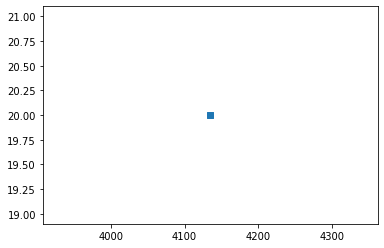

In [29]:
idx = 32


episode = episodes[idx]
transition = transitions[idx]
label = labels[idx]

sensor_list = sorted(set(episode[:,0]))

active_states = {item: [] for item in sensor_list}
current_state = {item: False for item in sensor_list}
active_start = {item: 0. for item in sensor_list}

on_times = []
on_sensors = []
for i in range(len(episode)):
    s, v, t = episode[i][:3]
    t = float(t)-float(episode[0][2])

    if v.lower() in ["on", "open", "true"]:
        if current_state[s]==False:
            active_start[s] = t
            current_state[s] = True
        on_times.append(t)
        on_sensors.append(s)
    elif v.lower() in ["off", "close", "false"]:
        if current_state[s]==True:
            active_states[s].append(
                (active_start[s], t)
            )
            current_state[s] = False
    
    for ck, cv in current_state.items():
        if cv==True and t-active_start[ck]>20.:
            active_states[ck].append(
                (active_start[ck], active_start[ck]+20.)
            )
            current_state[ck] = False


x = []
markerstring = ".sPDd"
for i, j in enumerate(active_states.items()):
    k, v = j
    data = []
    # print(k)
    index = sensor_list.index(k)
    if len(v)==0: continue
    for vv in v:
        data.append([vv[0], vv[1]-vv[0]])
        # label.append(index)
    x+=data
    data = np.array(data)
    # print(data)
    plt.scatter(data[:,0], data[:,1], label=k, marker=markerstring[i%len(markerstring)]) 
    # plt.bar(data[:,0], data[:,1], label=k) 

# x = [(ot, sensor_list.index(on_sensors[i])) for i, ot in enumerate(on_times)]
# x = np.array(x)
# plt.scatter(x[:,0], x[:,1])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.axvspan(float(episode[transition-1,2])-float(episode[0][2]),
    float(episode[transition,2])-float(episode[0][2]), color="g")
plt.title(label)
# print(episode)

In [23]:
from module_.info.adlmr import adlmr_location
from module_.info.hh import hh101_location
from itertools import combinations

sensors = set()
for events in episodes:
    sensors = sensors | set(events[:,0])
sensors = sorted(sensors)

sensor_distance = np.zeros((len(sensors), len(sensors)))
sensor_combinations = list(combinations(sensors, 2))

for l, r in sensor_combinations:
    # ax, ay = adlmr_location[l]
    # bx, by = adlmr_location[r]
    ax, ay = hh101_location[l]
    bx, by = hh101_location[r]
    row, col = max(sensors.index(l), sensors.index(r)), min(sensors.index(l), sensors.index(r))
    sensor_distance[row, col] = (ax-bx)**2+(ay-by)**2

sensor_distance/=float(np.max(sensor_distance))

In [27]:
from dbscan1d.core import DBSCAN1D
# https://github.com/d-chambers/dbscan1d

tp = tn = fp = fn = 0
for spl_idx in range(len(episodes)):
    
    s_tp = s_tn = s_fp = s_fn = 0

    episode, transition, label = episodes[spl_idx], transitions[spl_idx], labels[spl_idx]
    sensor_list = sorted(set(episode[:,0]))
    # print({j:item for j, item in enumerate(sensor_list)})

    sensor_initiation = {item: False for item in sensor_list}
    sensor_counter = {item: np.zeros(len(sensor_list)) for item in sensor_list}
    current_counter = np.zeros(len(sensor_list))

    on_events = []
    on_sensors = []
    on_intervals = []

    # print(transition, len(episode))

    transition_time_l = float(episode[transition-1][2])-float(episode[0][2])
    transition_time_r = float(episode[transition][2])-float(episode[0][2])

    sensor_membership = np.zeros((len(sensor_list), len(sensor_list)))
    before_membership = np.zeros((len(sensor_list)))
    prev_on_time = 0.
    before_labels = None
    before_sensor = None

    for i in range(len(episode)):
        s, v, t = episode[i][:3]
        t = float(t)-float(episode[0][2])
        sidx = sensor_list.index(s)
        positive_flag = False
        if v.lower() in ["on", "true", "open", "close"]:
            # Clustering할 Dataset에 추가함
            on_events.append(t)
            on_sensors.append(s)
            on_intervals.append(t-prev_on_time)
            prev_on_time = t

            # 선 판단
            # 1. 이전 이벤트로부터 정보 불러옴 (current_membership: 이전 이벤트가 갖는 유사도)
                # 다음 이벤트는 이전 이벤트 정보에서 높은 값을 갖는 센서일 가능성이 크다.

            if sensor_initiation[s]==False: # 1. 현재 센서가 최초 발현임 (당연히 before_membership[sidx]도 0임, 역은 성립 안 함)
                # print(f"{i, s, v} First Initiation")

                if before_sensor is not None:
                    # row, col = max(sensors.index(s), sensors.index(before_sensor)), min(sensors.index(s), sensors.index(before_sensor))
                    # normalized_distance = sensor_distance[row, col]
                    # print(normalized_distance)
                    # if normalized_distance>0.1:
                    #     # print(f"{i, s, v} Too far from previous sensor {before_sensor}.")
                    #     if abs(transition_time_l-t)<=5.:
                    #         s_tp+=1
                    #     elif abs(transition_time_r-t)<=5.:
                    #         s_tp+=1
                    #     else:
                    #         s_fp+=1
                    #     positive_flag = True

                    #     pass

                    pass

            if sum(before_membership)==0.: 
                #   1. 이전 이벤트 센서 A가 계속 최근 클러스터로부터 Noise였거나 
                #   2. 이전 이벤트 센서 A가 있었던 클러스터에는 계속 A 센서만 존재했어서 update가 안 되었음
                # print(f"{i, s, v} Noise or ...")
                pass

            elif 0<before_membership[sidx]/sum(before_membership)<0.12: # POSITIVE
                
                if abs(transition_time_l-t)<=5.:
                    s_tp+=1
                elif abs(transition_time_r-t)<=5.:
                    s_tp+=1
                else:
                    s_fp+=1
                positive_flag = True
                # 이전 센서가 가진 현재 센서 이벤트에 대한 유사도 = 0
                # 현재 센서가 이벤트를 발생시킨 적이 있었으나 이전 센서와 같은 클러스터에 있었던 적이 없음
                # relative_sim = before_membership[sidx]/sum(before_membership)
                # print(f"{i, s, v} Warning. {relative_sim}")
                # print(before_sensor, before_membership, before_membership[sidx]/sum(before_membership))
                # print(before_sensor, before_labels)
            
            if positive_flag==False:
                if i==transition-1:
                    s_fn+=1
                elif i==transition:
                    s_fn+=1
                else:
                    s_tn+=1


            # 후 업뎃
            # 1D-DBSCAN에 필요한 Parameter 결정: (eps, min_samples) # TODO
            median_ = np.median(on_intervals)
            # median_ = np.quantile(on_intervals, 0.25)
            eps_ = median_ if median_==0. else 15.
            dbs = DBSCAN1D(eps=2*eps_, min_samples=3)
            
            # 현재 들어온 센서를 포함시켜서 DBSCAN
            after_labels = dbs.fit_predict(np.array(on_events))

            # 그러나, 한번도 발현된 적 없던 센서가 발현되고 그 이벤트가 기존의 클러스터에 포함되는 경우 그냥 지나친다는 한계가 있음
            # 발현된 적 없는 센서들이 발현된다는 정보가 추가적으로 필요함. - 위치 정보?

            # print(i, s, v, t, labels)

            curr_label = after_labels[-1]
            if curr_label==-1: 
                # print(f"{i, s, v} Noise...")

                noise_events = []
                noise_sensors = []
                noise_intervals = []
                for pi in range(len(after_labels)-1, -1, -1):
                    if after_labels[pi]!=-1:
                        break
                    if after_labels[pi]==curr_label: # -1, -1
                        noise_events.append(on_events[pi])
                        noise_sensors.append(on_sensors[pi])
                        noise_intervals.append(on_events[pi]-on_events[pi-1])

                        # csidx = sensor_list.index(on_sensors[pi])
                        # row, col = max(sidx, csidx), min(sidx, csidx)
                        # # assert row!=col
                        # # sensor_membership[row, col]+=1/(1+2*np.exp(-(len(after_labels)-1-pi)))
                        # sensor_membership[row, col]+=0.5/(1+np.exp((t-on_events[pi]))) # TODO ***
                
                noise_events.reverse()
                noise_sensors.reverse()

                if noise_intervals:
                    eps_ = np.median(noise_intervals)
                    dbs_noise = DBSCAN1D(eps=2*eps_, min_samples=2)
                    noise_labels = dbs_noise.fit_predict(np.array(noise_events))

                    labels_dict= {l:[] for l in set(noise_labels)}
                    for ni in range(len(noise_labels)):
                        labels_dict[noise_labels[ni]].append(noise_sensors[ni])
                    for k, v in labels_dict.items():
                        if k==-1: continue
                        lnsidx = sensor_list.index(v[-1])
                        for idx in range(len(v)-2, -1, -1):
                            cnsidx = sensor_list.index(v[idx])
                            row, col = max(lnsidx, cnsidx), min(lnsidx, cnsidx)
                            sensor_membership[row, col]+=0.1/(1+np.exp(-(t-on_events[pi]))) # TODO ***


                            

                # it is noise data (outlier in contained data)
                # Case 1. same activity
                # Case 2. different activity
            else: 
                # 어떤 클러스터에 포함된다 - 이전 이벤트와 같은 카테고리
                # cluster_start_time = 0.
                # for pi in range(len(after_labels)-1):
                #     if after_labels[pi]==curr_label:
                #         cluster_start_time = on_events[pi]
                #         break
                
                
                for pi in range(len(after_labels)-1):
                    # curr_label과 동일한 클러스터 번호를 갖는 다른 센서들을 찾는다
                    # TODO: 이미 계산에 반영된 이벤트는 제외해야 한다..
                        # 최신 값이 추가되면서 기존 이벤트들의 Membership에 변동이 발생할 수 있음.
                        # 센서 A가 있는 클러스터 안에 센서 A만 있는 경우는?
                    # if after_labels[pi]==curr_label and on_sensors[pi]!=s:
                    if after_labels[pi]==curr_label:
                        # 센서 A의 ON (현재 이벤트)와 같은 클러스터에 있는 센서 B의 ON 이벤트 사이에는 당연히 시간 차이가 있을거다.
                        # 그 시간 차이가 가까울 수도 있고, 멀 수도 있다.
                        # 가까운 경우는 영향을 크게 줄 - 즉 같이 발현될 가능성이 큰 경우지만
                        # 먼 경우는 영향을 작게 줄 - 같이 발현될 가능성이 적은 경우
                        # 발생 시간 차이에 반비례하여 유사도가 정해져야 함

                        csidx = sensor_list.index(on_sensors[pi])
                        row, col = max(sidx, csidx), min(sidx, csidx)
                        # assert row!=col
                        # sensor_membership[row, col]+=1/(1+2*np.exp(-(len(after_labels)-1-pi))) # TODO ***
                        sensor_membership[row, col]+=1/(1+np.exp(-(t-on_events[pi]))) # TODO ***
            
            # Pass current information to next event
            # before_membership = sensor_membership[sidx,:]+sensor_membership[:,sidx].T
            before_membership = np.zeros(len(sensor_list))
            flag = False
            cluster_number = -1
            for idx in range(len(after_labels)-1, -1, -1):
                if flag and cluster_number!=after_labels[idx]:
                    break
                if after_labels[idx]!=-1:
                    flag=True
                    cluster_number = after_labels[idx]

                recent_sensor = on_sensors[idx]
                ridx = sensor_list.index(recent_sensor)
                before_membership+=sensor_membership[ridx,:]+sensor_membership[:,ridx].T

            before_labels = after_labels


            if sensor_initiation[s]!=True:
                sensor_initiation[s]=True
            before_sensor = s
        else:
            s_tn+=1
        
    tp+=s_tp
    fp+=s_fp
    tn+=s_tn
    fn+=s_fn


print(tp/(tp+fn), fp/(fp+tn))

0.7236842105263158 0.1644316396018858
